In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from brax import envs
from brax.io import mjcf
import jax
import flax.linen as nn
import jax.numpy as jnp
from wrappers import AutoResetWrapper

from custom_types import RNGKey, EnvState, Params
from typing import Any, Tuple, List
from algorithms import QuaraticPPO
from buffer import PPOTransition
from networks import MLP, PPO_Policy
from functools import partial
from utils import ppo_exploraive_rollout, shuffle_transitions, calculate_td_lambda_returns

/home_nfs/runjun/python_envs/qdax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
critic_hidden_layers: Tuple[int, ...] = (128, 128)
actor_hidden_layers: Tuple[int, ...] = (128, 128)

parallel_batch_size: int = 128
discount: float = 0.99
td_lambda_discount: float = 0.95

# PPO configs
rollout_length = 64
action_noise_std: float = 0.1


# actor_critic_iterations: int = 200 


# define learning rates
critic_learning_rate: float = 5e-4 # for critic training
policy_learning_rate: float = 5e-4 # Policy-Gradient step size


In [ ]:
# set random seed
seed = 42
loop_random_key = jax.random.PRNGKey(seed)
loop_random_key, subkey = jax.random.split(loop_random_key)
task_name = "ant"

# creat environment (Ant)
env = envs.create(env_name=task_name, episode_length=None, backend="mjx", auto_reset=False)
env = AutoResetWrapper(env) # custom auto reset

# define networks
policy_network = PPO_Policy(
    hidden_layer_sizes=actor_hidden_layers,
    action_dim=env.action_size,
    initial_log_std=jnp.log(action_noise_std) * jnp.ones(env.action_size),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    kernel_init_final=jax.nn.initializers.orthogonal(0.01),
    # activation=nn.softplus,
    activation=nn.softplus,
    final_activation=jnp.tanh,
    fixed_std=True,
)

critic_network = MLP(
    layer_sizes=critic_hidden_layers + (1,),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    activation=nn.softplus,
    final_activation=None,
)


ppo = QuaraticPPO(env, policy_network, critic_network, policy_learning_rate, critic_learning_rate, fixed_std=True, mean_kl_threshold=0.25)
ppo_training_state = ppo.init(subkey)

explorative_rollout = ppo_exploraive_rollout(
    policy_fn=policy_network.apply, 
    env_fn=env.step, 
    rollout_length=rollout_length, 
    )



In [5]:
loop_random_key, subkey = jax.random.split(loop_random_key)
subkeys = jax.random.split(subkey, num=parallel_batch_size)
states = jax.vmap(env.reset)(subkeys)

In [6]:
starting_states = states

In [25]:
num_iterations = 500


iteration_mean_returns = []
iteration_mean_rewards = []
iteration_mean_log_std = []


for i in range(num_iterations):
    states = starting_states

    loop_random_key, subkey = jax.random.split(loop_random_key)
    subkeys = jax.random.split(subkey, num=parallel_batch_size)

    policy_params = ppo_training_state.policy_params
    critic_params = ppo_training_state.critic_params

    (
        states, transitions
        ) = explorative_rollout(policy_params, states, subkeys)

    # loop_random_key, subkey = jax.random.split(loop_random_key)
    # subkeys = jax.random.split(subkey, num=parallel_batch_size)
    # states = jax.vmap(env.refresh_backup_state)(states)

    iteration_mean_rewards.append(jnp.mean(transitions.rewards))
    iteration_mean_log_std.append(jnp.mean(transitions.action_log_std))

    v_values = ppo.calculate_v(critic_params, transitions.obs)
    final_v_value = critic_network.apply(critic_params, states.obs)
    td_lambda_returns, weights = calculate_td_lambda_returns(
        final_v_value,
        v_values, 
        transitions.rewards,
        jnp.clip(1 - transitions.truncations - transitions.dones, min=0.0),
        discount,
        td_lambda_discount,
        ) # rollout x parallelize
    

    mean_change = jnp.average(td_lambda_returns - v_values, axis=0, weights=weights, keepdims=True) # 1 x parallelize
    td_lambda_returns = td_lambda_returns + (1 - weights) * mean_change # corrected td_lambda_returns

    gaes = td_lambda_returns - v_values
    gae_mean = jnp.mean(gaes)
    gae_std = jnp.std(gaes)
    gaes = jnp.clip(gaes, gae_mean - 4 * gae_std, gae_mean + 4 * gae_std) # clip oversized gae
    if gae_mean < 0 :
        gaes = gaes - gae_mean


    transitions = transitions.replace(
        td_lambda_returns=td_lambda_returns, 
        gaes=gaes,
        weights=weights,
        )
    
    loop_random_key, subkey = jax.random.split(loop_random_key)
    transitions = shuffle_transitions(subkey, transitions)
    
    transitions = jax.tree.map(
        lambda x: jnp.reshape(
            x,
            (
                -1,
                512,
                *x.shape[1:],
            ),
        ),
        transitions)
    

    # Training policy & critic
    # ppo_training = partial(ppo.train, epochs=4)
    ppo_training_state = ppo.train(ppo_training_state, transitions, critic_epoch=16, policy_epoch=16)
    
    iteration_mean_returns.append(jnp.mean(td_lambda_returns))

    if (i + 1) % max([(num_iterations // 10), 1]) == 0:
        print(int((i + 1) / num_iterations * 100), "% complete")


10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
100 % complete


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

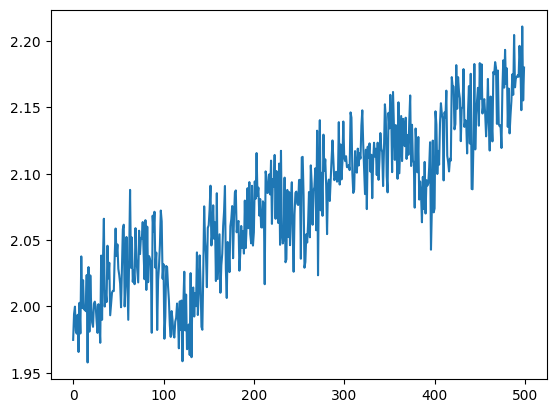

In [27]:
plt.plot(jnp.arange(num_iterations), iteration_mean_rewards)
# plt.plot(jnp.arange(num_iterations), iteration_mean_log_std)
plt.show()

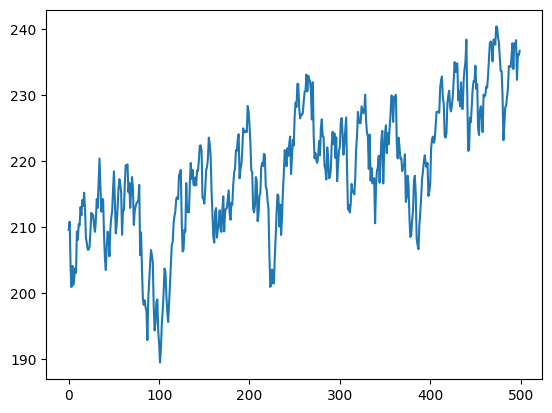

In [28]:
plt.plot(jnp.arange(num_iterations), iteration_mean_returns)
plt.savefig(f"{algo_name}_{task_name}_{num_iterations}.png")
# plt.show()

In [29]:
# jnp.std(transitions.gaes)

# jnp.mean(transitions.gaes)

jnp.mean(v_values)



Array(236.10184, dtype=float32)

In [30]:
# jnp.mean(states.metrics["x_velocity"])

jnp.mean(transitions.rewards) * 100

Array(217.99722, dtype=float32)